with max of feature = 100,000 and 50,000, the k-fold evaluation method changed into train-test with rasio 80:20

# 1. Setup dataset and libraries

## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

from scipy.sparse import csr_matrix, vstack
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

folder_path = "..../dataset/"

# 2. Read train and test processed data 

In [3]:
df_train = pd.read_csv( folder_path+"processed_movie_dataset_train.csv" )
df_train.head( 5 )

,review,merged_tokens_one,merged_tokens_many,sentiment,sentiment_number
0,"There have been many movies featuring Bigfoot,...",mani movi featur bigfoot major good least goof...,mani movi featur bigfoot major good least goof...,negative,0
1,The plot: A crime lord is uniting 3 different ...,plot crime lord unit differ mafia entrepris bu...,plot crime lord unit differ mafia entrepris bu...,positive,1
2,"It's great to hear the 3 or so comments, that ...",great hear comment point footbal wive signifi ...,great hear comment point footbal wive signifi ...,negative,0
3,"A great story, based on a true story about a y...",great stori base true stori young black man di...,great stori base true stori young black man di...,positive,1
4,This film is the proof that a good actor is no...,film proof good actor noth without good direct...,film proof good actor noth without good direct...,negative,0


In [4]:
df_test = pd.read_csv( folder_path+"processed_movie_dataset_test.csv" )
df_test.head( 5 )

,review,merged_tokens_one,merged_tokens_many,sentiment,sentiment_number
0,I gave this movie a chance only because it had...,gave movi chanc good review see trailer though...,gave movi chanc good review. see trailer thoug...,negative,0
1,"This is full of major spoilers, so beware.<br ...",full major spoiler bewar prix de beaut alway s...,full major spoiler bewar. prix de beaut alway ...,positive,1
2,Never saw the original movie in the series...I...,never saw origin movi seri hope much better mo...,never saw origin movi seri hope much better mo...,negative,0
3,This is a film that is far more enjoyable than...,film far enjoy rate would suggest mani way lik...,film far enjoy rate would suggest. mani way li...,positive,1
4,This was intolerable. (SPOILER #1) Protagonist...,intoler spoiler protagonist avoid pointless di...,intoler. spoiler protagonist avoid pointless d...,negative,0


## set train and test set variables

In [5]:
# target variables
y_train = df_train['sentiment_number'].copy()
y_test  = df_test['sentiment_number'].copy()

# depended variables
X_train_ori = df_train['review']
X_test_ori  = df_test['review']

X_tokens_one_train  = df_train['merged_tokens_one'].copy()
X_tokens_one_test   = df_test['merged_tokens_one'].copy()

X_tokens_many_train = df_train['merged_tokens_many'].copy()
X_tokens_many_test  = df_test['merged_tokens_many'].copy()

# 3. Continue Feature Extraction Step by using vectorizer

ref:
- https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/
- https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/
- ChatGPT

## set vectorizer

### create vectorizer function with different settings of ngram

In [6]:
# to create a vectorizer with sklearn countvectorizer function
def create_vectorizer( input_docs, ngram_start=1, ngram_end=1, max_features_number=1000 ):
  # create a corpus from input documents
  corpus = " ".join( input_docs )

  # create a CountVectorizer object with desired n-gram range
  vectorizer = CountVectorizer( max_features=max_features_number, ngram_range=( ngram_start, ngram_end ), binary=True )

  # fit the vectorizer to the concatenated corpus
  vectorizer.fit( [ corpus ] )

  # get the shared vocabulary of n-grams
  vocabulary = vectorizer.get_feature_names_out()

  # return vocab list and the vectrizer obj
  return vocabulary, vectorizer
# end func

### since there's limitation with the computation of array size, the max features for each vectorizer are assigned default in the create_vectorizer function

#### create vectorizer with train set and max features 100k

In [7]:
# create ngrams for models with max features is 100,000 or 100k
unigram_vocab_100k, unigram_vectorizer_100k           = create_vectorizer( df_train['merged_tokens_one'], 1, 1, 100000 )
bigram_vocab_100k, bigram_vectorizer_100k             = create_vectorizer( df_train['merged_tokens_one'], 2, 2, 100000 )
trigram_vocab_100k, trigram_vectorizer_100k           = create_vectorizer( df_train['merged_tokens_one'], 3, 3, 100000 )
unibigram_vocab_100k, unibigram_vectorizer_100k       = create_vectorizer( df_train['merged_tokens_one'], 1, 2, 100000 )
unibitrigram_vocab_100k, unibitrigram_vectorizer_100k = create_vectorizer( df_train['merged_tokens_one'], 1, 3, 100000 )

# check current length of vocabulary on each ngram vectorizer
print( "len of unigram_vocab_100k:", len( unigram_vocab_100k ) )
print( "len of bigram_vocab_100k:", len( bigram_vocab_100k ) )
print( "len of trigram_vocab_100k:", len( trigram_vocab_100k ) )
print( "len of unibigram_vocab_100k:", len( unibigram_vocab_100k ) )
print( "len of unibitrigram_vocab_100k:", len( unibitrigram_vocab_100k ) )

len of unigram_vocab_100k: 38837
len of bigram_vocab_100k: 100000
len of trigram_vocab_100k: 100000
len of unibigram_vocab_100k: 100000
len of unibitrigram_vocab_100k: 100000


#### create vectorizer with train set and max features 50k

In [8]:
# create ngrams for models
unigram_vocab_50k, unigram_vectorizer_50k           = create_vectorizer( df_train['merged_tokens_one'], 1, 1, 50000 )
bigram_vocab_50k, bigram_vectorizer_50k             = create_vectorizer( df_train['merged_tokens_one'], 2, 2, 50000 )
trigram_vocab_50k, trigram_vectorizer_50k           = create_vectorizer( df_train['merged_tokens_one'], 3, 3, 50000 )
unibigram_vocab_50k, unibigram_vectorizer_50k       = create_vectorizer( df_train['merged_tokens_one'], 1, 2, 50000 )
unibitrigram_vocab_50k, unibitrigram_vectorizer_50k = create_vectorizer( df_train['merged_tokens_one'], 1, 3, 50000 )

# check current length of vocabulary on each ngram vectorizer
print( "len of unigram_vocab_50k:", len( unigram_vocab_50k ) )
print( "len of bigram_vocab_50k:", len( bigram_vocab_50k ) )
print( "len of trigram_vocab_50k:", len( trigram_vocab_50k ) )
print( "len of unibigram_vocab_50k:", len( unibigram_vocab_50k ) )
print( "len of unibitrigram_vocab_50k:", len( unibitrigram_vocab_50k ) )

len of unigram_vocab_50k: 38837
len of bigram_vocab_50k: 50000
len of trigram_vocab_50k: 50000
len of unibigram_vocab_50k: 50000
len of unibitrigram_vocab_50k: 50000


#### transform all review tokens with created vectorizers

In [9]:
# to transform each sentence from one review and merge it into one sparse matrix
def transform_text_per_sentence( input_docs, input_vectorizer ):
  # Initialize list to store merged sparse matrices for each review
  all_sparse_matrices = []
  # all_sparse_matrices = None

  # loop all review data
  for input_text in input_docs:
    # split each sentence from input text
    splited_txt = input_text.split( ". " )

    # initialize merged matrix
    merged_sparse_matrix = None

    # Loop through each document's vector and perform OR operation
    for sentence in splited_txt:
      # transform each sentence with vectorizer and transform its form into sprase matrix
      one_sparse_matrix = input_vectorizer.transform( [ sentence ] ).astype( int )

      # combine with previous sparse matrix
      # if merged_sparse_matrix is None:
      if merged_sparse_matrix is None:
        merged_sparse_matrix = one_sparse_matrix.toarray()
      else:
        # Perform OR operation with the result vector
        merged_sparse_matrix = np.logical_or( merged_sparse_matrix, one_sparse_matrix.toarray() ).astype( int )
      # end if
    # end loop

    # convert into sparse matrix
    merged_sparse_matrix = csr_matrix( merged_sparse_matrix )

    # append the merged sparse matrix into the final matrix list
    all_sparse_matrices.append( merged_sparse_matrix )
  # end loop

  # return final result with stacking all the created matrices
  return vstack( all_sparse_matrices )
# end func


#### create unigram matrixes as X_data

n-grams matrixes with max features 100k

In [10]:
# unigram matrixes
# a) with one token sentence
X_unigram_matrix_100k_sentence_one_train = unigram_vectorizer_100k.transform( X_tokens_one_train )
X_unigram_matrix_100k_sentence_one_test  = unigram_vectorizer_100k.transform( X_tokens_one_test )
# b) with many token sentence
X_unigram_matrix_100k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, unigram_vectorizer_100k )
X_unigram_matrix_100k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, unigram_vectorizer_100k )


# bigram matrixes
# a) with one token sentence
X_bigram_matrix_100k_sentence_one_train = bigram_vectorizer_100k.transform( X_tokens_one_train )
X_bigram_matrix_100k_sentence_one_test  = bigram_vectorizer_100k.transform( X_tokens_one_test )
# b) with many token sentence
X_bigram_matrix_100k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, bigram_vectorizer_100k )
X_bigram_matrix_100k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, bigram_vectorizer_100k )


# trigram matrixes
# a) with one token sentence
X_trigram_matrix_100k_sentence_one_train = trigram_vectorizer_100k.transform( X_tokens_one_train )
X_trigram_matrix_100k_sentence_one_test  = trigram_vectorizer_100k.transform( X_tokens_one_test )
# b) with many token sentence
X_trigram_matrix_100k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, trigram_vectorizer_100k )
X_trigram_matrix_100k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, trigram_vectorizer_100k )


# unibigram matrixes ( unigram + bigram matrixes )
# a) with one token sentence
X_unibigram_matrix_100k_sentence_one_train = unibigram_vectorizer_100k.transform( X_tokens_one_train )
X_unibigram_matrix_100k_sentence_one_test  = unibigram_vectorizer_100k.transform( X_tokens_one_test )
# b) with many token sentence
X_unibigram_matrix_100k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, unibigram_vectorizer_100k )
X_unibigram_matrix_100k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, unibigram_vectorizer_100k )


# unibitrigram matrixes ( unigram + bigram + trigram matrixes )
# a) with one token sentence
X_unibitrigram_matrix_100k_sentence_one_train = unibitrigram_vectorizer_100k.transform( X_tokens_one_train )
X_unibitrigram_matrix_100k_sentence_one_test  = unibitrigram_vectorizer_100k.transform( X_tokens_one_test )
# b) with many token sentence
X_unibitrigram_matrix_100k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, unibitrigram_vectorizer_100k )
X_unibitrigram_matrix_100k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, unibitrigram_vectorizer_100k )


n-grams matrixes with max features 50k

In [11]:
# unigram matrixes
# a) with one token sentence
X_unigram_matrix_50k_sentence_one_train = unigram_vectorizer_50k.transform( X_tokens_one_train )
X_unigram_matrix_50k_sentence_one_test  = unigram_vectorizer_50k.transform( X_tokens_one_test )
# b) with many token sentence
X_unigram_matrix_50k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, unigram_vectorizer_50k )
X_unigram_matrix_50k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, unigram_vectorizer_50k )


# bigram matrixes
# a) with one token sentence
X_bigram_matrix_50k_sentence_one_train = bigram_vectorizer_50k.transform( X_tokens_one_train )
X_bigram_matrix_50k_sentence_one_test  = bigram_vectorizer_50k.transform( X_tokens_one_test )
# b) with many token sentence
X_bigram_matrix_50k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, bigram_vectorizer_50k )
X_bigram_matrix_50k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, bigram_vectorizer_50k )


# trigram matrixes
# a) with one token sentence
X_trigram_matrix_50k_sentence_one_train = trigram_vectorizer_50k.transform( X_tokens_one_train )
X_trigram_matrix_50k_sentence_one_test  = trigram_vectorizer_50k.transform( X_tokens_one_test )
# b) with many token sentence
X_trigram_matrix_50k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, trigram_vectorizer_50k )
X_trigram_matrix_50k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, trigram_vectorizer_50k )


# unibigram matrixes ( unigram + bigram matrixes )
# a) with one token sentence
X_unibigram_matrix_50k_sentence_one_train = unibigram_vectorizer_50k.transform( X_tokens_one_train )
X_unibigram_matrix_50k_sentence_one_test  = unibigram_vectorizer_50k.transform( X_tokens_one_test )
# b) with many token sentence
X_unibigram_matrix_50k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, unibigram_vectorizer_50k )
X_unibigram_matrix_50k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, unibigram_vectorizer_50k )


# unibitrigram matrixes ( unigram + bigram + trigram matrixes )
# a) with one token sentence
X_unibitrigram_matrix_50k_sentence_one_train = unibitrigram_vectorizer_50k.transform( X_tokens_one_train )
X_unibitrigram_matrix_50k_sentence_one_test  = unibitrigram_vectorizer_50k.transform( X_tokens_one_test )
# b) with many token sentence
X_unibitrigram_matrix_50k_sentence_many_train = transform_text_per_sentence( X_tokens_many_train, unibitrigram_vectorizer_50k )
X_unibitrigram_matrix_50k_sentence_many_test  = transform_text_per_sentence( X_tokens_many_test, unibitrigram_vectorizer_50k )


# 4. Modeling Sentiment Classifier Model with SVM with Linear Kernel

Modeling SVM with Linear Kernel

In [12]:
# create SVM model, with Linear Kernel
svm_model = SVC( kernel='linear' )

# 5. Evaluate Sentiment Classifier Model with SVM

In [13]:
# to evaluate model with train-test data
def evaluate_model( X_train, X_test, y_train, y_test, input_model, type_token_schema='one', file_name='prediction_results' ):
  # Convert sparse matrix into dense array
  X_train_dense = X_train.toarray()
  X_test_dense = X_test.toarray()

  # Record start time
  start_time = time.time()

  # Train the model
  input_model.fit( X_train_dense, y_train )

  # Do prediction
  y_pred = input_model.predict( X_test_dense )

  # Record end time
  end_time = time.time()

  # Calculate running time
  final_running_time = end_time - start_time

  # default schema type
  X_tokens_list = X_tokens_one_test.copy()
  if ( type_token_schema!="one" ):
    X_tokens_list = X_tokens_many_test.copy()
  # end if

  # save prediction results in dataframe
  predictions_results_csv = pd.concat( [ X_test_ori.copy(), X_tokens_list ], axis=1 )
  predictions_results_csv['sentiment_real'] = y_test.copy()
  predictions_results_csv['sentiment_prediction'] = y_pred.copy()
  predictions_results_csv.to_csv( folder_path+"results/"+file_name+".csv", index=False )

  # Compute evaluation metrics
  print(
    "- Accuracy:", accuracy_score( y_test, y_pred ), "\n", 
    "- Precision:", precision_score( y_test, y_pred ), "\n", 
    "- Recall:", recall_score( y_test, y_pred ), "\n", 
    "- F1-score:", f1_score( y_test, y_pred ), "\n", 
    "- Running Time (seconds):", final_running_time, "\n", 
    "- Running Time (minutes):", final_running_time / 60
  )

  # Show confusion matrix
  display_confusion_matrix_and_reports_results( y_test, y_pred, input_model )
# end function

# to show confusion matrix and classification report from current results
def display_confusion_matrix_and_reports_results( y_true, y_pred, input_model ):
  # show classification report
  print( '\n Classification Report: \n', classification_report( y_true, y_pred ) )
  
  # show visualized confusion matrix 
  display_result = ConfusionMatrixDisplay( confusion_matrix=confusion_matrix( y_true, y_pred, labels=input_model.classes_ ), display_labels=input_model.classes_ )
  display_result.plot()
  plt.show()
# end function

## performance evaluation of SVM model

### for max feature = 100k

unigram matrixes

Evaluation Results for NB model with Unigram and One Sentence Matrix: 

- Accuracy: 0.835 
 - Precision: 0.8316831683168316 
 - Recall: 0.84 
 - F1-score: 0.835820895522388 
 - Running Time (seconds): 999.7415208816528 
 - Running Time (minutes): 16.66235868136088

 Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.83      0.84      0.84      1000

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



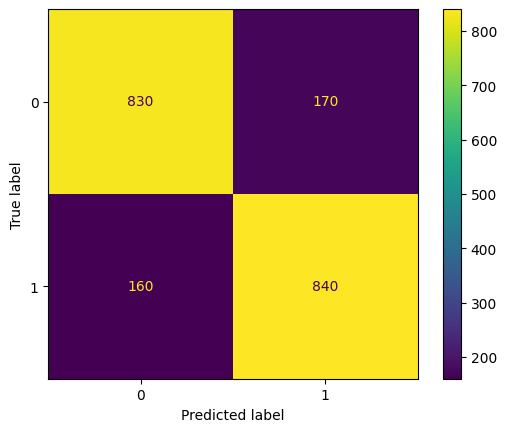

Evaluation Results for NB model with Unigram and Many Sentence Matrix: 

- Accuracy: 0.835 
 - Precision: 0.8316831683168316 
 - Recall: 0.84 
 - F1-score: 0.835820895522388 
 - Running Time (seconds): 962.8561775684357 
 - Running Time (minutes): 16.047602959473927

 Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.83      0.84      0.84      1000

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



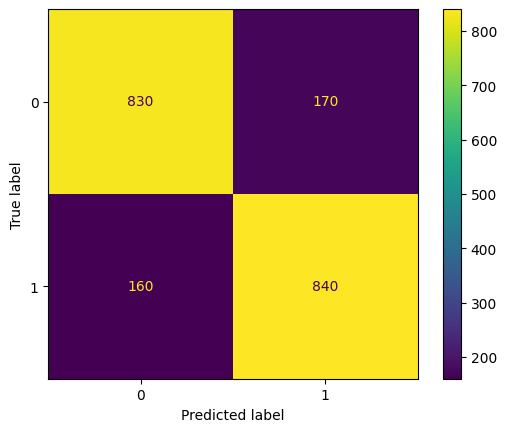

In [14]:
# a) with one token sentence
print( "Evaluation Results for SVM model with Unigram and One Sentence Matrix: \n" )
evaluate_model( X_unigram_matrix_100k_sentence_one_train, X_unigram_matrix_100k_sentence_one_test, y_train, y_test, svm_model, type_token_schema='one', file_name='SVM_Unigram_One-Sentence-Matrix_100k' )

# b) with many token sentence
print( "Evaluation Results for SVM model with Unigram and Many Sentence Matrix: \n" )
evaluate_model( X_unigram_matrix_100k_sentence_many_train, X_unigram_matrix_100k_sentence_many_test, y_train, y_test, svm_model, type_token_schema='many', file_name='SVM_Unigram_Many-Sentence-Matrix_100k' )



bigram matrixes

Evaluation Results for NB model with Bigram and One Sentence Matrix: 

- Accuracy: 0.676 
 - Precision: 0.6644859813084112 
 - Recall: 0.711 
 - F1-score: 0.6869565217391305 
 - Running Time (seconds): 6058.798884391785 
 - Running Time (minutes): 100.97998140652975

 Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.64      0.66      1000
           1       0.66      0.71      0.69      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



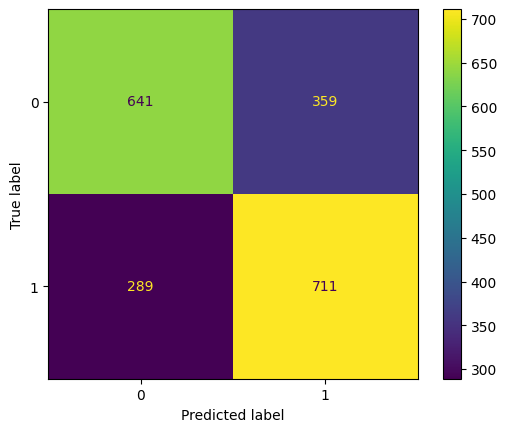

Evaluation Results for NB model with Bigram and Many Sentence Matrix: 

- Accuracy: 0.674 
 - Precision: 0.6608133086876156 
 - Recall: 0.715 
 - F1-score: 0.6868395773294909 
 - Running Time (seconds): 6024.4730813503265 
 - Running Time (minutes): 100.4078846891721

 Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.63      0.66      1000
           1       0.66      0.71      0.69      1000

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



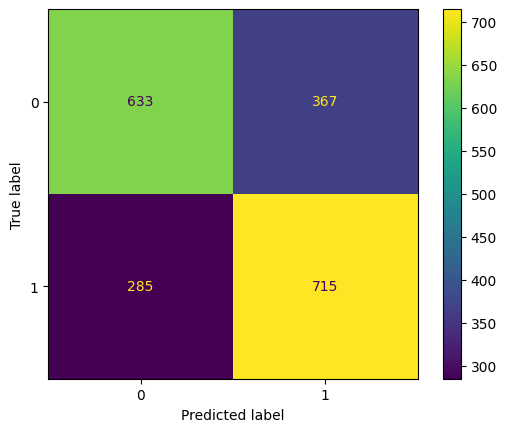

In [15]:
# a) with one token sentence
print( "Evaluation Results for SVM model with Bigram and One Sentence Matrix: \n" )
evaluate_model( X_bigram_matrix_100k_sentence_one_train, X_bigram_matrix_100k_sentence_one_test, y_train, y_test, svm_model, type_token_schema='one', file_name='SVM_Bigram_One-Sentence-Matrix_100k' )

# b) with many token sentence
print( "Evaluation Results for SVM model with Bigram and Many Sentence Matrix: \n" )
evaluate_model( X_bigram_matrix_100k_sentence_many_train, X_bigram_matrix_100k_sentence_many_test, y_train, y_test, svm_model, type_token_schema='many', file_name='SVM_Bigram_Many-Sentence-Matrix_100k' )


trigram matrixes

Evaluation Results for NB model with Trigram and One Sentence Matrix: 

- Accuracy: 0.543 
 - Precision: 0.525 
 - Recall: 0.903 
 - F1-score: 0.6639705882352941 
 - Running Time (seconds): 8679.894415140152 
 - Running Time (minutes): 144.66490691900253

 Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.18      0.29      1000
           1       0.53      0.90      0.66      1000

    accuracy                           0.54      2000
   macro avg       0.59      0.54      0.47      2000
weighted avg       0.59      0.54      0.47      2000



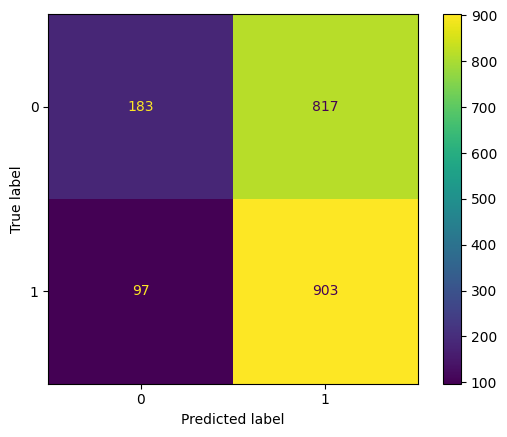

Evaluation Results for NB model with Trigram and Many Sentence Matrix: 

- Accuracy: 0.547 
 - Precision: 0.5276796230859835 
 - Recall: 0.896 
 - F1-score: 0.6641957005189029 
 - Running Time (seconds): 8240.614125490189 
 - Running Time (minutes): 137.34356875816982

 Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.20      0.30      1000
           1       0.53      0.90      0.66      1000

    accuracy                           0.55      2000
   macro avg       0.59      0.55      0.48      2000
weighted avg       0.59      0.55      0.48      2000



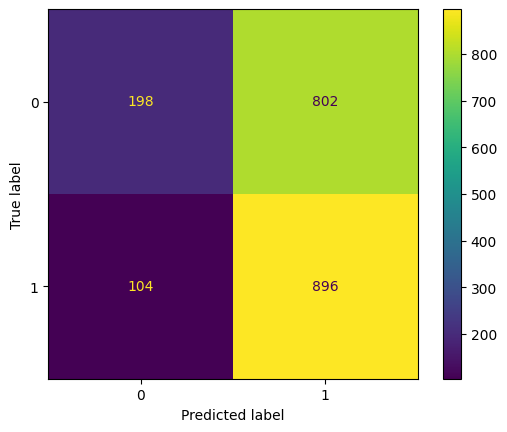

In [16]:
# a) with one token sentence
print( "Evaluation Results for SVM model with Trigram and One Sentence Matrix: \n" )
evaluate_model( X_trigram_matrix_100k_sentence_one_train, X_trigram_matrix_100k_sentence_one_test, y_train, y_test, svm_model, type_token_schema='one', file_name='SVM_Trigram_One-Sentence-Matrix_100k' )

# b) with many token sentence
print( "Evaluation Results for SVM model with Trigram and Many Sentence Matrix: \n" )
evaluate_model( X_trigram_matrix_100k_sentence_many_train, X_trigram_matrix_100k_sentence_many_test, y_train, y_test, svm_model, type_token_schema='many', file_name='SVM_Trigram_Many-Sentence-Matrix_100k' )



unigram + bigram matrixes

Evaluation Results for NB model with Unigram + Bigram and One Sentence Matrix: 

- Accuracy: 0.718 
 - Precision: 0.7141453831041258 
 - Recall: 0.727 
 - F1-score: 0.7205153617443013 
 - Running Time (seconds): 4453.614175319672 
 - Running Time (minutes): 74.22690292199452

 Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.71      0.72      1000
           1       0.71      0.73      0.72      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



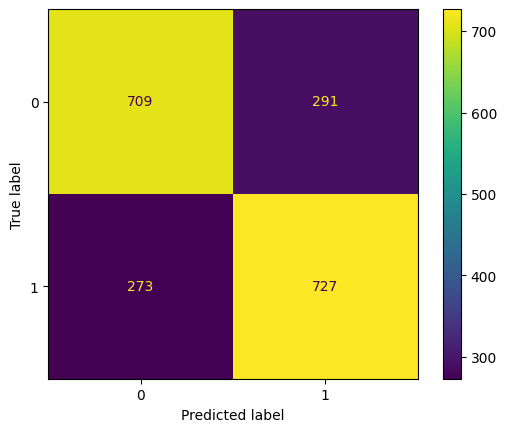

Evaluation Results for NB model with Unigram + Bigram and Many Sentence Matrix: 

- Accuracy: 0.7265 
 - Precision: 0.7188405797101449 
 - Recall: 0.744 
 - F1-score: 0.7312039312039312 
 - Running Time (seconds): 4372.389943599701 
 - Running Time (minutes): 72.87316572666168

 Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.71      0.72      1000
           1       0.72      0.74      0.73      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



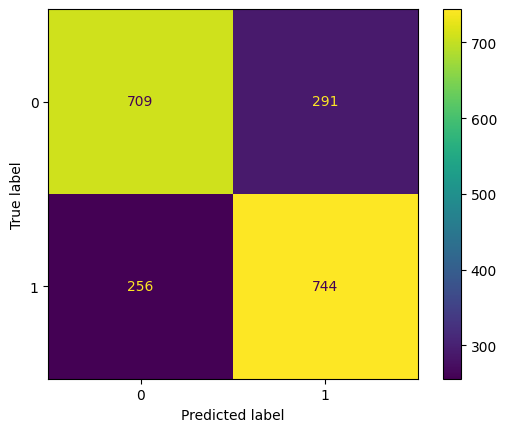

In [17]:
# a) with one token sentence
print( "Evaluation Results for SVM model with Unigram + Bigram and One Sentence Matrix: \n" )
evaluate_model( X_unibigram_matrix_100k_sentence_one_train, X_unibigram_matrix_100k_sentence_one_test, y_train, y_test, svm_model, type_token_schema='one', file_name='SVM_Uni-Bigram_One-Sentence-Matrix_100k' )

# b) with many token sentence
print( "Evaluation Results for SVM model with Unigram + Bigram and Many Sentence Matrix: \n" )
evaluate_model( X_unibigram_matrix_100k_sentence_many_train, X_unibigram_matrix_100k_sentence_many_test, y_train, y_test, svm_model, type_token_schema='many', file_name='SVM_Uni-Bigram_Many-Sentence-Matrix_100k' )


unigram + bigram + trigram matrixes

Evaluation Results for NB model with Unigram + Bigram + Trigram and One Sentence Matrix: 

- Accuracy: 0.681 
 - Precision: 0.661319073083779 
 - Recall: 0.742 
 - F1-score: 0.6993402450518379 
 - Running Time (seconds): 4660.705311059952 
 - Running Time (minutes): 77.6784218509992

 Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.62      0.66      1000
           1       0.66      0.74      0.70      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



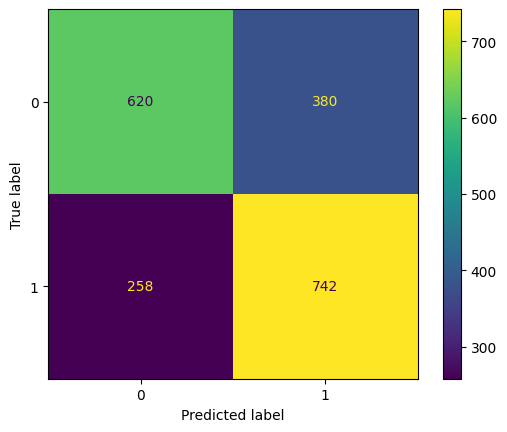

Evaluation Results for NB model with Unigram + Bigram + Trigram and Many Sentence Matrix: 

- Accuracy: 0.6835 
 - Precision: 0.6651665166516652 
 - Recall: 0.739 
 - F1-score: 0.7001421127427759 
 - Running Time (seconds): 4152.643626451492 
 - Running Time (minutes): 69.21072710752487

 Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.63      0.66      1000
           1       0.67      0.74      0.70      1000

    accuracy                           0.68      2000
   macro avg       0.69      0.68      0.68      2000
weighted avg       0.69      0.68      0.68      2000



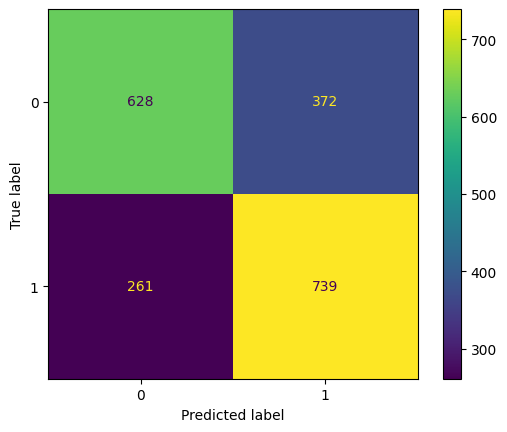

In [18]:
# a) with one token sentence
print( "Evaluation Results for SVM model with Unigram + Bigram + Trigram and One Sentence Matrix: \n" )
evaluate_model( X_unibitrigram_matrix_100k_sentence_one_train, X_unibitrigram_matrix_100k_sentence_one_test, y_train, y_test, svm_model, type_token_schema='one', file_name='SVM_Uni-Bi-Trigram_One-Sentence-Matrix_100k' )

# b) with many token sentence
print( "Evaluation Results for SVM model with Unigram + Bigram + Trigram and Many Sentence Matrix: \n" )
evaluate_model( X_unibitrigram_matrix_100k_sentence_many_train, X_unibitrigram_matrix_100k_sentence_many_test, y_train, y_test, svm_model, type_token_schema='many', file_name='SVM_Uni-Bi-Trigram_Many-Sentence-Matrix_100k' )

